# **Project Name** - Financial Forecasting Frontier: Distributed Machine Learning for Banking Analytics

# **Project Type** - Real-Time Data Analytics Project

# **Contribution** - Individual

# **GitHub link** - https://github.com/Mihirjain05/Financial-Forecasting-Frontier

# **Project Summary**

This project focuses on building a scalable, distributed machine learning system for banking analytics using Apache Spark. The objective is to analyze large-scale customer and transaction data to uncover behavioral patterns, predict term deposit subscriptions, and enable real-time decision-making. The project combines deep exploratory data analysis, robust data preprocessing, predictive modeling, model evaluation, and real-time streaming analytics. By leveraging distributed computing and data parallelism, the solution demonstrates how modern banks can efficiently process high-volume data and deploy predictive models for strategic planning and customer targeting.

# **Problem statement:**

Banks generate massive volumes of customer and transaction data daily; however, traditional data processing and analytics approaches struggle to scale and provide timely insights. There is a need for a distributed, scalable system that can efficiently analyze historical banking data, predict customer behavior such as term deposit subscription, and process real-time transaction streams for immediate insights. The challenge lies in handling large-scale data, performing accurate predictive modeling, enabling real-time analytics, and ensuring efficient resource utilization in a distributed environment.

In [80]:
# hdfs dfs -mkdir /banking
# hdfs dfs -put bank.csv /banking/


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve, auc


In [83]:
spark = SparkSession.builder \
    .appName("FinancialForecastingFrontier") \
    .getOrCreate()


In [84]:
df = spark.read.csv("/content/bank.csv", header=True, inferSchema=True)
df.show(5)
df.printSchema()


+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|  5|  may|     22

In [85]:
df.groupBy("y").count().show()


+---+-----+
|  y|count|
+---+-----+
| no| 4000|
|yes|  521|
+---+-----+



In [86]:
df.describe(["age","balance","duration","campaign","previous"]).show()


+-------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|          duration|          campaign|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|              4521|              4521|              4521|              4521|              4521|
|   mean| 41.17009511170095|1422.6578190665782|263.96129174961294| 2.793629727936297|0.5425790754257908|
| stddev|10.576210958711263|3009.6381424673395|259.85663262468216|3.1098066601885823|1.6935623506071211|
|    min|                19|             -3313|                 4|                 1|                 0|
|    max|                87|             71188|              3025|                50|                25|
+-------+------------------+------------------+------------------+------------------+------------------+



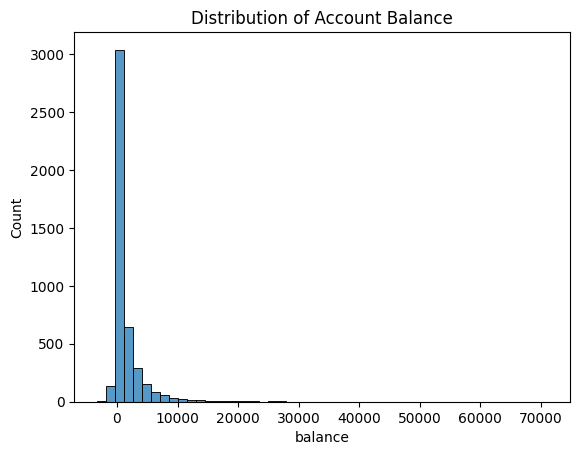

In [87]:
pdf_num = df.select("balance","y").toPandas()

sns.histplot(pdf_num["balance"], bins=50)
plt.title("Distribution of Account Balance")
plt.show()


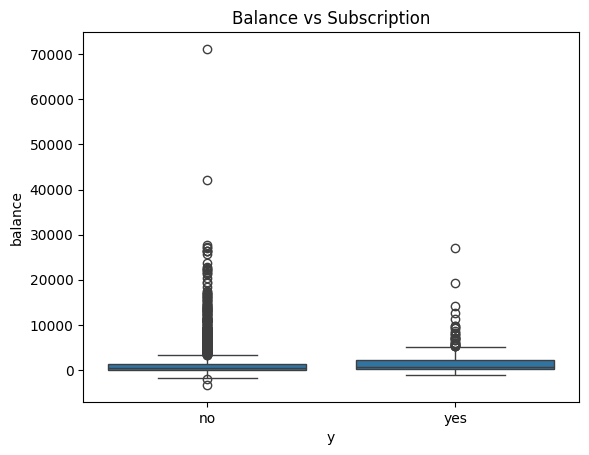

In [88]:
sns.boxplot(x="y", y="balance", data=pdf_num)
plt.title("Balance vs Subscription")
plt.show()


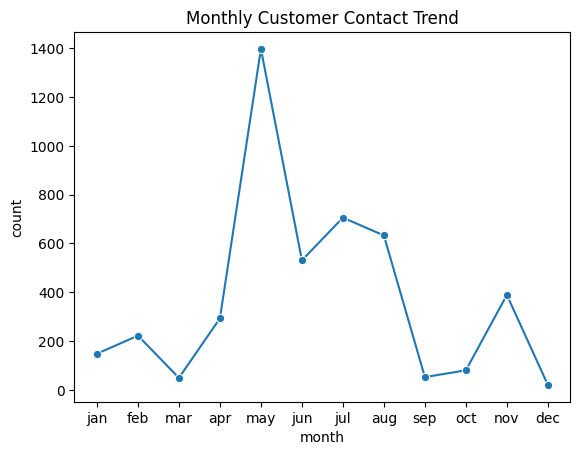

In [89]:
month_order = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]

monthly = df.groupBy("month").count().toPandas()
monthly["month"] = pd.Categorical(monthly["month"], month_order, ordered=True)
monthly = monthly.sort_values("month")

sns.lineplot(x="month", y="count", data=monthly, marker="o")
plt.title("Monthly Customer Contact Trend")
plt.show()


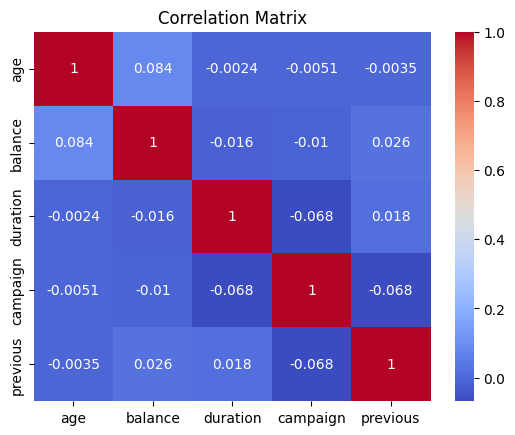

In [90]:
corr_pdf = df.select("age","balance","duration","campaign","previous").toPandas()
sns.heatmap(corr_pdf.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


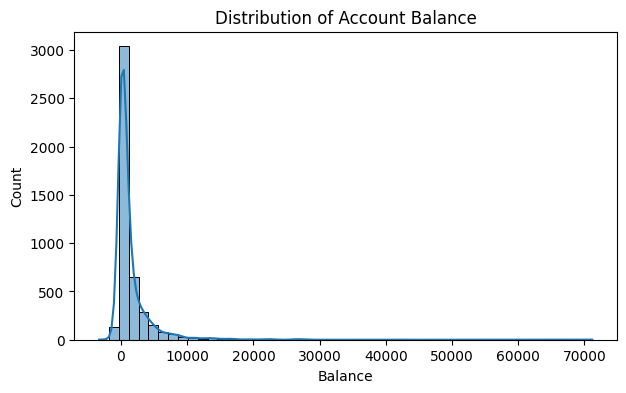

In [91]:
pdf_balance = df.select("balance").toPandas()

plt.figure(figsize=(7,4))
sns.histplot(pdf_balance["balance"], bins=50, kde=True)
plt.title("Distribution of Account Balance")
plt.xlabel("Balance")
plt.ylabel("Count")
plt.show()


In [95]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



In [96]:
low, high = df.approxQuantile("balance",[0.01,0.99],0.05)

df = df.withColumn(
    "balance",
    F.when(df.balance < low, low)
     .when(df.balance > high, high)
     .otherwise(df.balance)
)


In [97]:
def age_bucket(age):
    if age < 30: return "<30"
    elif age <= 60: return "30-60"
    else: return ">60"

df = df.withColumn("age_group", F.udf(age_bucket,StringType())("age"))


In [98]:
df = df.withColumn(
    "quarter",
    F.when(df.month.isin("jan","feb","mar"),"Q1")
     .when(df.month.isin("apr","may","jun"),"Q2")
     .when(df.month.isin("jul","aug","sep"),"Q3")
     .otherwise("Q4")
)


In [99]:
df.rdd.getNumPartitions()


1

In [100]:
df = df.repartition(8, "job")
df.rdd.getNumPartitions()


8

In [102]:
df.groupBy("job").avg("balance").show()


+-------------+------------------+
|          job|      avg(balance)|
+-------------+------------------+
|   management|1766.9287925696594|
|       admin.|  1226.73640167364|
|      retired| 2319.191304347826|
|   unemployed|       1089.421875|
|     services|1103.9568345323742|
|      student|1543.8214285714287|
|      unknown|1501.7105263157894|
|  blue-collar| 1085.161733615222|
|self-employed|1392.4098360655737|
|   technician|     1330.99609375|
|    housemaid|2083.8035714285716|
| entrepreneur|          1645.125|
+-------------+------------------+



In [103]:
label_indexer = StringIndexer(inputCol="y", outputCol="label")

cat_cols = ["job","marital","education","housing","loan","contact","poutcome","age_group"]
indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") for c in cat_cols]

assembler = VectorAssembler(
    inputCols=["age","balance","duration","campaign","previous"] + [c+"_idx" for c in cat_cols],
    outputCol="features"
)


In [104]:
train, test = df.randomSplit([0.8,0.2], seed=42)
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")


In [105]:
models = {
    "Logistic Regression": LogisticRegression(maxIter=30),
    "Random Forest": RandomForestClassifier(numTrees=100, maxDepth=6),
    "Gradient Boosted Trees": GBTClassifier(maxIter=50)
}


In [106]:
trained_models = {}
auc_scores = {}

for name, algo in models.items():
    pipeline = Pipeline(stages=indexers+[label_indexer,assembler,algo])
    model = pipeline.fit(train)
    auc = evaluator.evaluate(model.transform(test))
    trained_models[name] = model
    auc_scores[name] = auc


In [107]:
auc_scores

{'Logistic Regression': 0.8670950644355591,
 'Random Forest': 0.8688012289074688,
 'Gradient Boosted Trees': 0.8488256194373767}

In [108]:
best_model_name = max(auc_scores, key=auc_scores.get)
best_model = trained_models[best_model_name]


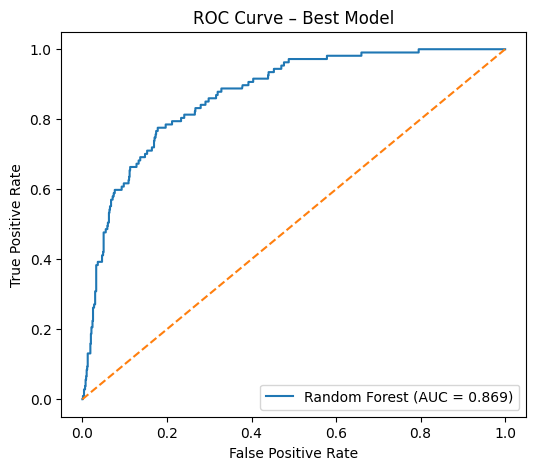

In [111]:
model_path = "/content/best_model"
best_model.write().overwrite().save(model_path)
from sklearn.metrics import roc_curve, auc as sk_auc

roc_df = best_model.transform(test).select(
    F.col("label"),
    vector_to_array("probability")[1].alias("prob")
).toPandas()

fpr, tpr, _ = roc_curve(roc_df["label"], roc_df["prob"])
roc_auc = sk_auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Best Model")
plt.legend()
plt.show()


In [113]:
model_path = "/content/best_model"
best_model.write().overwrite().save(model_path)

In [114]:
loaded_model = PipelineModel.load(model_path)

In [115]:
stream_df = spark.readStream \
    .format("socket") \
    .option("host","localhost") \
    .option("port",9999) \
    .load()

In [116]:
parsed = stream_df.select(
    F.from_json(stream_df.value, df.schema).alias("data")
).select("data.*")

In [117]:
windowed = parsed.withColumn("ts", F.current_timestamp()) \
    .withWatermark("ts","1 minute") \
    .groupBy(F.window("ts","10 seconds")) \
    .count()

In [119]:
query = windowed.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()

In [ ]:
live_predictions = loaded_model.transform(parsed)

**Thankyou!**